# Test of least square error fit of orbital elements to range data

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value

In [2]:
sampling_interval = 180
sample_offsets = np.arange(0, (canberra_start-goldstone_end)/(1*u.s), sampling_interval)
flyby_epochs = goldstone_end + (sample_offsets << u.s)
print("Start and end epochs:", goldstone_end, flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 06:14:55.600 1998-01-23 09:53:55.600 [ 74 ]


In [3]:
near_goldstone_end_rv = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_goldstone_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 37309.07130107391 km 73145.82143191747 km
Start and end radial speeds: -7.97119272554438 km / s 7.3216176182785535 km / s
Closest: 11326.436162795784 km speed 12.740147538216107 km / s  at  1998-01-23 07:23:55.600
Deflection: 64.92614895100142 deg


In [5]:
ref_data = []
meas_data = []
for o in sample_offsets:
    e = goldstone_end + o*u.s
    ref_r, ref_rr = dss25.range_and_rate(near_goldstone_ephem.rv(e), e)
    ref_data.append(ref_r)
    meas_data.append(ref_r - ref_rr*ref_r/const.c)

print(ref_data)
print(meas_data)

[<Quantity 31576.17444216 km>, <Quantity 30192.56575694 km>, <Quantity 28808.41297044 km>, <Quantity 27424.19037991 km>, <Quantity 26040.54434311 km>, <Quantity 24658.35299324 km>, <Quantity 23278.80941126 km>, <Quantity 21903.53881781 km>, <Quantity 20534.76568879 km>, <Quantity 19175.55494194 km>, <Quantity 17830.16401278 km>, <Quantity 16504.56175734 km>, <Quantity 15207.19758059 km>, <Quantity 13950.13898309 km>, <Quantity 12750.72461251 km>, <Quantity 11633.85108674 km>, <Quantity 10634.77439507 km>, <Quantity 9801.52784106 km>, <Quantity 9194.34466982 km>, <Quantity 8877.46150324 km>, <Quantity 8900.22209027 km>, <Quantity 9273.93069523 km>, <Quantity 9960.4981254 km>, <Quantity 10883.33638425 km>, <Quantity 11956.87696072 km>, <Quantity 13116.93865255 km>, <Quantity 14329.05738607 km>, <Quantity 15577.51544465 km>, <Quantity 16854.11052459 km>, <Quantity 18153.1314273 km>, <Quantity 19469.92047735 km>, <Quantity 20800.5719156 km>, <Quantity 22141.85444579 km>, <Quantity 23491.14

In [6]:
from lmfit import Parameters, minimize, fit_report

fit_params = Parameters()
fit_params.add('a', min=-8600e3, max=-8200e3, value=near_goldstone_orbit.a.to_value(u.m))
fit_params.add('inc', min=0, max=np.pi, value=near_goldstone_orbit.inc.to_value(u.rad))
fit_params.add('ecc', min=1.7, max=1.9, value=near_goldstone_orbit.ecc.to_value(u.one))
fit_params.add('nu', min=-np.pi, max=np.pi, value=near_goldstone_orbit.nu.to_value(u.rad))
fit_params.add('raan', min=0, max=2*np.pi, value=near_goldstone_orbit.raan.to_value(u.rad))
fit_params.add('argp', min=0, max=2*np.pi, value=near_goldstone_orbit.argp.to_value(u.rad))

def residual(pars, offsets, data):
    vals = pars.valuesdict()
    print(vals)
    orbit = Orbit.from_classical(attractor=Earth,
                                 a=vals['a']*u.m,
                                 ecc=vals['ecc']*u.one,
                                 inc=vals['inc']*u.rad,
                                 raan=vals['raan']*u.rad,
                                 argp=vals['argp']*u.rad,
                                 nu=vals['nu']*u.rad,
                                 epoch=goldstone_end,
                                 plane=Planes.EARTH_EQUATOR)
    ephem = orbit.to_ephem(EpochsArray(flyby_epochs))
    rres = []
    for i, v in enumerate(offsets):
        e = goldstone_end + v*u.s
        meas_r = data[i]
        model_r, model_rr = dss25.range_and_rate(ephem.rv(e), e)
        rres.append((model_r - meas_r).to_value(u.m))
    return rres

In [7]:
out = minimize(residual, fit_params, args=(sample_offsets,), kws={'data': meas_data})
print(fit_report(out))

{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.038199617, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478545592624, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.81335709173224, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981

In [8]:
print(out.residual)

[-11.35384581 -11.3676025  -10.78441094  -9.60040492  -7.8185573
  -5.45189471  -2.52812509   0.9036765    4.76338461   8.92580664
  13.20052581  17.30343987  20.81825129  23.14929609  23.47801638
  20.7655158   13.91167609   2.2882765  -13.12513129 -28.32485589
 -36.35449281 -31.12932022 -13.64261592   6.15430094  17.5665326
  19.01592237  15.53804151  11.49499534   8.61687945   7.09130792
   6.58481165   6.69911618   7.11186497   7.59662488   8.0073099
   8.25703865   8.30011116   8.11856721   7.71271019   7.09460523
   6.2836835    5.3037966    4.18125825   2.94355333   1.61849637
   0.23369375  -1.18379116  -2.60763611  -4.01236695  -5.37340526
  -6.66707609  -7.87059122  -8.96201713  -9.92023433 -10.72489198
 -11.35636146 -11.79568962 -12.02455461 -12.02522294 -11.78050986
 -11.27374241 -10.48872486  -9.40970782  -8.02135927  -6.30873835
  -4.25727188  -1.85273254   0.91878112   4.07086164   7.61680963
  11.56964742  15.94213293  20.7467713   25.99582552]


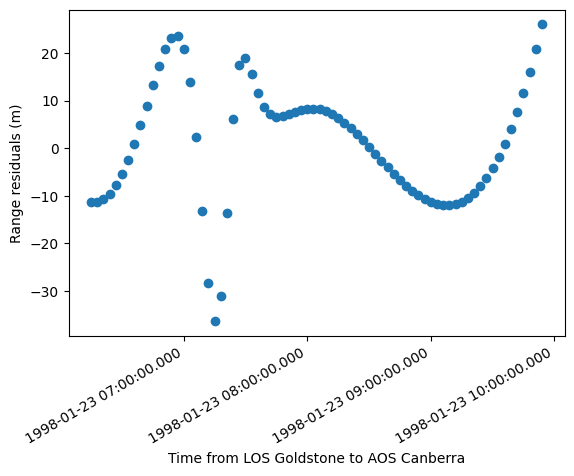

In [11]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time from LOS Goldstone to AOS Canberra')
    plt.ylabel('Range residuals (m)')
    plt.scatter(flyby_epochs, out.residual)
    plt.gcf().autofmt_xdate()